In [6]:
import math
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
import torchaudio.transforms as TT
import librosa
import os
from tqdm import tqdm
import gc

In [7]:
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler, LTPlugin

In [8]:
UNet = LTPlugin(
    UNetV0, num_filters=128, window_length=64,stride=64
)

In [32]:
dataset = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

directory = '/nas/home/jalbarracin/datasets/hrir_st'

for files in os.listdir(directory):
    f = os.path.join(directory, files)
    wave, sr = torchaudio.load(f, normalize=True)
    dataset.append(wave)

Using device: cuda


In [33]:
print(f"Dataset length: {len(dataset)}")
print(f"Sample channels and length: {dataset[0].shape}")

Dataset length: 3096
Sample channels and length: torch.Size([2, 256])


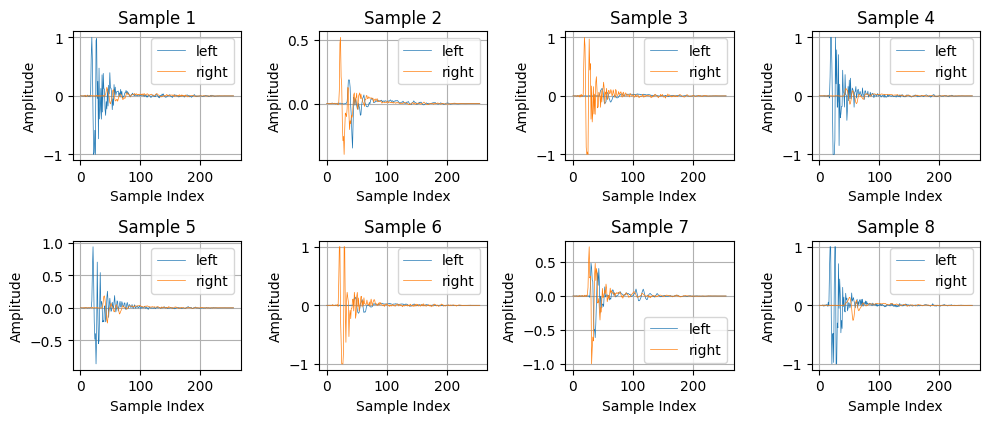

In [34]:
def show_waveforms(dataset, num_samples=20, cols=4):
    """ Plots some samples from the audio dataset """
    plt.figure(figsize=(10, 6)) 
    for i, item in enumerate(dataset):
        if i == num_samples:
            break
        if isinstance(item, tuple):
            waveform, _ = item
        else:
            waveform = item
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.plot(waveform[0].numpy(), label='left', linewidth=0.5)
        plt.plot(waveform[1].numpy(), label='right', linewidth=0.5)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()
show_waveforms(dataset, num_samples=8, cols=4)

In [38]:
for n in range(len(dataset)):
    dataset[n] = np.transpose(dataset[n])
print(dataset[10].shape)

torch.Size([256, 2])


In [39]:
def collate_fn(batch):
    # Assuming each element in batch is a tensor of shape (2, 256)
    return torch.stack([item.squeeze(0) for item in batch])

In [40]:
BATCH_SIZE = 1 # len(dataset) // 4
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)
audio_test = next(iter(dataloader))[0]
print(audio_test.shape)

torch.Size([256, 2])


In [46]:
model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=256, # U-Net: number of input/output (audio) channels
    channels=[4, 16, 32, 64, 128, 256, 256, 512, 512], # U-Net: channels at each layer
    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    attentions=[0, 0, 0, 0, 0, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
    attention_heads=8, # U-Net: number of attention heads per attention item
    attention_features=64, # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler, # The diffusion sampler used
)

print("Num params: ", sum(p.numel() for p in model.parameters()))
model

ValueError: num_channels must be divisible by num_groups

In [42]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()
epoch = 0  # Try more!
step = 0
NUM_SAMPLES = 256
SAMPLE_RATE = 44100

In [43]:
model.train()
while epoch < 100:
        avg_loss = 0
        avg_loss_step = 0
        progress = tqdm(dataloader)
        for i, audio in enumerate(progress):
            optimizer.zero_grad()
            audio = audio.to(device)
            print(audio[0].shape)
            with torch.cuda.amp.autocast():
                loss = model(audio)
                avg_loss += loss.item()
                avg_loss_step += 1
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            progress.set_postfix(
                loss=loss.item(),
                epoch=epoch + i / len(dataloader),
            )

            if step % 500 == 0:
                # Turn noise into new audio sample with diffusion
                noise = torch.randn(BATCH_SIZE, 2, NUM_SAMPLES, device=device)
                with torch.cuda.amp.autocast():
                    sample = model.sample(noise, num_steps=100)

                torchaudio.save(f'test_generated_sound_{step}.wav', sample[0].cpu(), SAMPLE_RATE)
                del sample
                gc.collect()
                torch.cuda.empty_cache()

            if step % 100 == 0:
                avg_loss = 0
                avg_loss_step = 0

            step += 1
        checkpoint_path = f"checkpoint_epoch_{epoch}_lib.pt"
        epoch += 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)

  0%|          | 0/3096 [00:00<?, ?it/s]


torch.Size([256, 2])


RuntimeError: Calculated padded input size per channel: (2). Kernel size: (4). Kernel size can't be greater than actual input size

In [19]:
loss_history = []
for i in range(epoch):
  for x in iter(dataloader):
    loss = model(x)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss)